## Imports

In [1]:

#utils
import numpy as np 
import pandas as pd
from glob import glob
import tensorflow as tf

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Preproc
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import backend as K

#model
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, GlobalMaxPooling2D,MaxPooling2D
from keras.layers import Activation,Dense

#metrics
from sklearn import metrics
from keras.metrics import categorical_accuracy
from sklearn.metrics import classification_report,confusion_matrix,f1_score, precision_score
import time

## Globals

In [2]:
'''
We use fixed seed to make the data set reproducible
'''
seed = 5
np.random.seed(seed)
#dimensions
img_width, img_height = 64,64

#data dirs
train_data_dir = './img/train/'
test_data_dir = './img/val/'

#Classes/labels
class_types = ['Malware','Benign']

In [3]:
#Class/label setup
num_classes = 2 #malware & benign

#Setting up input tuple shape for the model.
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, None)
else:
    input_shape = (img_width, None,1)
input_shape

(64, None, 1)

## Model Description

In [4]:
'''
Creation of the Sequential model.
1st layer: input_layer = creates a starting point for the data to enter by giving all of them a uniform 
shape from where they can traverse through the rest of the model.

2nd Layer: Covolution 2D layer = This layer creates a convolution kernel that is convolved with the layer
input to produce a tensor of outputs.
    params: 
            filters,
            kernel shape,
            activation function,
    The input layer has been passed as the layer before it.

3rd layer: MaxPooling2D layer= Downsamples the input along its spatial dimensions(no.of pixels in this case)
or(height and width) by taking the maximum value over an input window (of size defined by pool_size) for each
channel of the input The window is shifted by strides along each dimension.
    params:
        filters,
        pool_size
    The last layer has been passed as a parameter to get the input shape.

4th layer: Convolution 2D layer= Same as before

5th layer: Global MaxPooling2D = The ordering of the dimensions in the inputs. channels_last corresponds 
to inputs with shape (batch, height, width, channels)
while channels_first corresponds to inputs with shape (batch, channels, height, width) .
refer = https://keras.io/api/layers/pooling_layers/global_max_pooling2d/

6th layer = Dense layer = The dense layer’s neuron in a model receives output from every neuron 
of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication. 
Implementation : https://keras.io/api/layers/core_layers/dense/
    params:
        units,
        activation function

7th layer: Output Layer = Again a Dense layer with only 1 unit and sigmoid activation to normalize the output

'''
def model(input_shape):
    input_layer = layers.Input(shape = input_shape)
    x = Conv2D(32,(3,3),activation='relu')(input_layer)
    x = MaxPooling2D(32,(2,2))(x)
    x = Conv2D(72,(3,3),activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(256,activation='softmax')(x)
    output_layer = Dense(1,activation='sigmoid')(x)
    model = Model(inputs =input_layer,outputs = output_layer,name='CNN')
    return model

In [5]:
model = model(input_shape)

#Compiling
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
'''
We use loss function "binary crossentrop" because we are classifying between 2 classes, benign and malware.
"adam" refer: https://keras.io/api/optimizers/adam/
'''
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, None, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, None, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, None, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, None, 72)      20808     
_________________________________________________________________
global_max_pooling2d (Global (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               18688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257     

## Data Generation

In [6]:
#Use ImageDataGenerator to feed image files from directories
train_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

'''
We implement 2 data generator here which create the training an test data sets.
The generators take in the folloeing parameters
params:
    path_to_directory,color_mode,target_size, batch_size, class_mode
The directory passed as parameter has 2 child directories which contain the 2 classes of image data
(benign and malware). All the data images are greyscale images. The target size is 64x64 pixels.
We create batches of 10 images which will be precessed at once.
'''
train_generator = train_datagen.flow_from_directory(
                          train_data_dir,
                          color_mode='grayscale',
                          target_size = (64,64),
                          batch_size = 10,
                          class_mode = 'binary')


test_generator = test_datagen.flow_from_directory(
                  test_data_dir,
                  color_mode='grayscale',
                  target_size=(img_width, img_width),
              batch_size=10,
              class_mode='binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Fitting Model

In [7]:
start_time = time.time()
'''
The fitting of the model has been done with by runnning the data through the model 20 times 
20 epochs, we have the same number of epochs for the validation data as well.
'''
history = model.fit(train_generator, steps_per_epoch=20, validation_data=test_generator, 
                              validation_steps=20,epochs=20)

print("CNN model execution time took %s seconds" % (time.time() - start_time))

Epoch 1/20
20/20 [==============================] - 11s 465ms/step - loss: 0.6920 - accuracy: 0.5917 - val_loss: 0.6936 - val_accuracy: 0.4800
Epoch 2/20
20/20 [==============================] - 6s 303ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6945 - val_accuracy: 0.4500
Epoch 3/20
20/20 [==============================] - 5s 254ms/step - loss: 0.6916 - accuracy: 0.5022 - val_loss: 0.6910 - val_accuracy: 0.4900
Epoch 4/20
20/20 [==============================] - 5s 262ms/step - loss: 0.6947 - accuracy: 0.4489 - val_loss: 0.6919 - val_accuracy: 0.4450
Epoch 5/20
20/20 [==============================] - 5s 257ms/step - loss: 0.6944 - accuracy: 0.3870 - val_loss: 0.6860 - val_accuracy: 0.4800
Epoch 6/20
20/20 [==============================] - 5s 235ms/step - loss: 0.6853 - accuracy: 0.5048 - val_loss: 0.6736 - val_accuracy: 0.5250
Epoch 7/20
20/20 [==============================] - 5s 231ms/step - loss: 0.6808 - accuracy: 0.5731 - val_loss: 0.6605 - val_accuracy: 0.6800
Epoch

## Metrics

### Confusion Matrix

In [8]:
#contains all the predictions made by the model ,array of[0-1] values
probabilities = model.predict(test_generator)

y_true = test_generator.classes
y_pred = probabilities>0.49873
plt.rc('font')
#confusion matrix store the true +ve, true-ve, etc etc values
mat = confusion_matrix(y_true, y_pred)
mat

array([[174, 226],
       [153, 247]], dtype=int64)

### Precision Score

In [9]:

precision_score = metrics.precision_score(y_true,y_pred,average='macro')
print(f"Test precision : {precision_score:.1%}")

Test precision : 52.7%


### F1 Score

In [10]:
f1_score = metrics.f1_score(y_true,y_pred)
print(f"F1 score :{f1_score: .1%}")

F1 score : 56.6%


### Recall Score

In [11]:
r1 = metrics.recall_score(y_true,y_pred,average = "macro")
print(f"Recall score :{r1: .1%}")

Recall score : 52.6%


## Visualisation

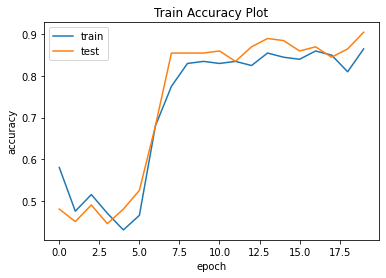

In [12]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Train Accuracy Plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

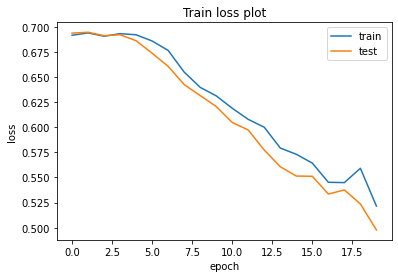

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Train loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

## Heatmap

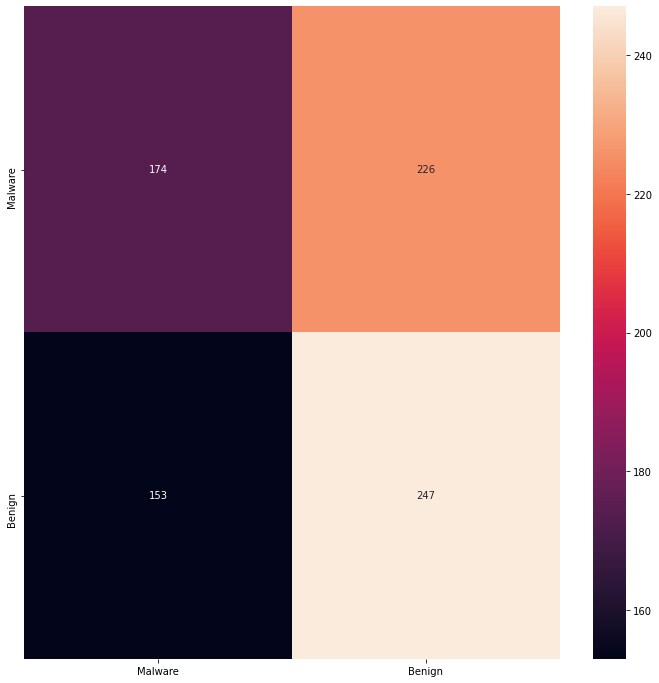

In [14]:
#visualization of confusion matrix
plt.figure(figsize=(12,12))
sns_hmp = sns.heatmap(mat, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
fig = sns_hmp.get_figure()